# CST 383 – Intro to Data Science
### Project 2: Predicting Kickstarter Goal Completion
**Authors:** Brianna Magallon, Tyler Pruitt, Rafael L.S. Reis

## Introduction
In this project, we use the Kickstarter Projects dataset to build a model that predicts whether a crowdfunding campaign will succeed or fail based on information available at launch. Each entry includes metadata such as goal amount, number of backers, campaign duration, and category.

We treat this as a binary classification problem, where the outcomes are `'successful'` or `'failed'`. We merge `'canceled'` campaigns into the `'failed'` category, based on the observation that they typically don't meet funding goals.

**Dataset Source:**  
[Kickstarter Projects (Kaggle)](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

In [4]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

In [5]:
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

## Data Exploration

In [7]:
df = pd.read_csv("ks-projects-201612.csv", low_memory=False)
#df = pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False)

In [8]:
df.columns = df.columns.str.strip()
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
255257,588940772,The REAL Costs of Self-Publishing,Fiction,Publishing,USD,2016-03-05 01:21:24,2500,2016-01-05 01:21:24,10,failed,1,US,10,NaN,NaN,NaN,NaN
11403,1066799733,Art + Food: An Edible Urban Oasis (Canceled),Food,Food,USD,2011-04-12 05:59:00,5000,2011-02-10 22:51:22,963,canceled,21,US,963,NaN,NaN,NaN,NaN
198385,248306542,Super Car,Product Design,Design,USD,2014-09-15 01:53:08,75000,2014-07-17 01:53:08,0,failed,0,US,0,NaN,NaN,NaN,NaN
79134,1470114501,Universal Maths Buddy [UMB],Academic,Publishing,AUD,2016-05-29 10:59:13,1500,2016-04-29 10:59:13,110,failed,3,AU,83.5539287,NaN,NaN,NaN,NaN
13261,1077991931,The Desert Peach in Concert,Theater,Theater,USD,2013-11-22 18:53:10,15000,2013-10-23 18:53:10,2061,failed,30,US,2061,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323750 non-null  int64  
 1   name           323746 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   deadline       323750 non-null  object 
 6   goal           323750 non-null  object 
 7   launched       323750 non-null  object 
 8   pledged        323750 non-null  object 
 9   state          323750 non-null  object 
 10  backers        323750 non-null  object 
 11  country        323750 non-null  object 
 12  usd pledged    319960 non-null  object 
 13  Unnamed: 13    625 non-null     object 
 14  Unnamed: 14    12 non-null      object 
 15  Unnamed: 15    4 non-null       object 
 16  Unnamed: 16    1 non-null       float64
dtypes: float64(1), int64(1), obje

In [10]:
df['state'].value_counts()

state
failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
2312               1
320                1
477                1
1404               1
2634               1
Name: count, Length: 410, dtype: int64

In [11]:
df[df['state'] == "canceled"].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN
59,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000,2015-07-08 21:46:53,700,canceled,6,CA,553.324254,NaN,NaN,NaN,NaN
61,1000260691,Gizbeeô Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000,2016-02-29 20:30:27,2030,canceled,15,US,2030,NaN,NaN,NaN,NaN


In [12]:
df['country'].value_counts()

country
US      257565
GB       27509
CA       11992
AU        6236
N,"0      3790
         ...  
582          1
26           1
27           1
136          1
176          1
Name: count, Length: 162, dtype: int64

In [13]:
dftest = df[df['country'] == 'US']
dftest = dftest.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

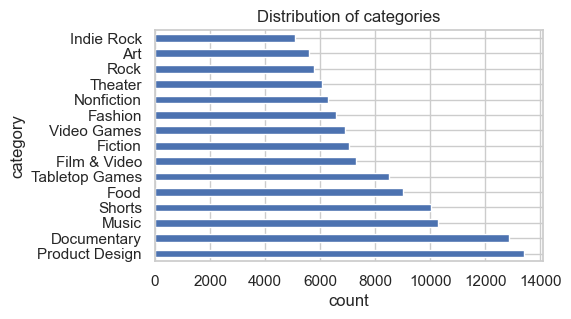

In [14]:
category_counts = dftest['category'].value_counts().head(15)
category_counts.plot.barh()
plt.title('Distribution of categories')
plt.xlabel('count')
plt.ylabel('category')
plt.show()

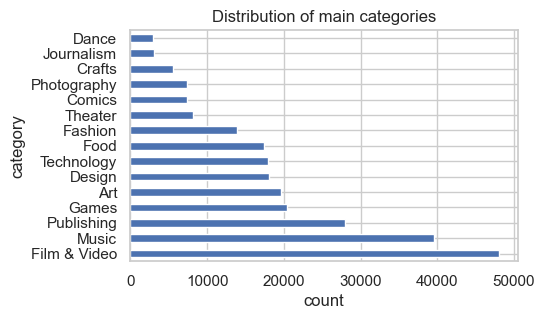

In [15]:
main_category_count = dftest['main_category'].value_counts()
main_category_count.plot.barh()
plt.title('Distribution of main categories')
plt.xlabel('count')
plt.ylabel('category')
plt.show()

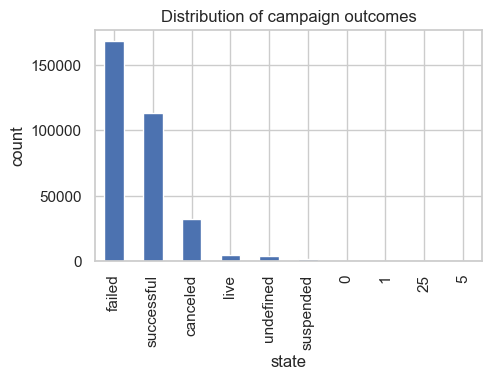

In [16]:
state_counts = df['state'].value_counts().head(10)
state_counts.plot.bar()
plt.title('Distribution of campaign outcomes')
plt.xlabel('state')
plt.ylabel('count')
plt.show()

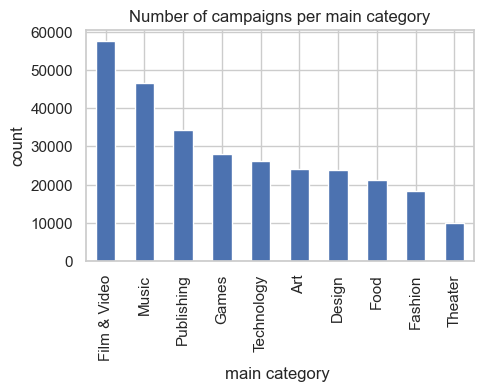

In [17]:
df['main_category'].value_counts().head(10).plot.bar()
plt.title("Number of campaigns per main category")
plt.xlabel("main category ")
plt.ylabel("count")
plt.show()

## Data Cleaning & Preprocessing

We begin cleaning by dropping empty or irrelevant columns and filtering to U.S.-based projects.

Campaign titles might include important information about the type of project, which could be predictive of success. To explore this, we want to extract the most common meaningful words from the campaign titles and create new features.  

In [20]:
df['lower_title'] = df['name'].str.lower()
df['words'] = df['lower_title'].str.split()
#turn all words into one big series
all_words = df['words'].explode()
word_counts = all_words.value_counts()
#remove meaningless words
stopwords = ['the', 'a', 'of', 'and', 'for', 'to', 'in', '&', '-', '(canceled)', 'by', 'your', 'with', 'on', 'an', 'my', 'new', 'from', 'first', 'short', 'is', 'you', 'help', 'at']
filtered_words = word_counts[~word_counts.index.isin(stopwords)]
print(filtered_words.head(10))

words
album          9352
film           9257
project        9229
book           7136
game           6575
art            6312
music          6134
debut          4395
documentary    3532
life           3352
Name: count, dtype: int64


In [21]:
top_words = ['album', 'film', 'project', 'book', 'game', 'art', 'music', 'debut', 'documentary', 'life']
for word in top_words:
    df[f'has_{word}'] = df['lower_title'].str.contains(rf'\b{word}\b', na=False).astype(int)

#show the new columns
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'lower_title', 'words', 'has_album', 'has_film',
       'has_project', 'has_book', 'has_game', 'has_art', 'has_music',
       'has_debut', 'has_documentary', 'has_life'],
      dtype='object')

In [22]:
df = df.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [23]:
df[df.isnull().any(axis=1)].sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,has_album,has_film,has_project,has_book,has_game,has_art,has_music,has_debut,has_documentary,has_life
74631,1443513306,New Children Awaken!,Publishing,Publishing,USD,2015-06-20 20:47:11,8000,2015-05-21 20:47:11,925,undefined,...,0,0,0,0,0,0,0,0,0,0
60693,1360744175,Invitation - My Debut Album,Music,Music,USD,2014-11-05 07:49:03,5000,2014-10-06 07:49:03,8150,undefined,...,1,0,0,0,0,0,0,1,0,0
3608,1021555390,White Light Cemetery album pre-sale,Music,Music,USD,2015-08-20 04:20:23,1500,2015-07-21 04:20:23,1507,undefined,...,1,0,0,0,0,0,0,0,0,0
6251,1036980077,Summer Kick Starter,Music,Music,USD,2015-05-25 15:40:54,6500,2015-05-05 15:40:54,0,undefined,...,0,0,0,0,0,0,0,0,0,0
209438,314621036,BSM: World's Most Unique VIDEO-DELIVERY | Capt...,Film & Video,Film & Video,USD,2015-10-15 02:06:12,5000,2015-09-15 02:06:12,7170,undefined,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df = df[df['state'].isin(["successful", "failed", "canceled"])]

In [25]:
print("Rows still with null values: ", len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)].sample(5)

Rows still with null values:  235


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,has_album,has_film,has_project,has_book,has_game,has_art,has_music,has_debut,has_documentary,has_life
94440,1561007131,Discover yourself - Be awareness,Publishing,Publishing,EUR,2016-05-14 19:23:14,5000,2016-03-15 18:23:14,2,failed,...,0,0,0,0,0,0,0,0,0,0
234876,466994278,CutLeaf Productions,Film & Video,Film & Video,GBP,2016-07-01 18:47:00,4500,2016-05-21 20:45:12,200,canceled,...,0,0,0,0,0,0,0,0,0,0
130932,1777232090,Ukulele Circus - Jimmy Denis / First Solo Ukul...,Music,Music,EUR,2016-05-16 05:30:00,4070,2016-04-14 11:32:37,4150,successful,...,1,0,0,0,0,0,0,0,0,0
264730,645829934,IFs... a new album from 'UNA,Music,Music,GBP,2016-05-19 15:04:19,3000,2016-04-19 15:04:19,3129,successful,...,1,0,0,0,0,0,0,0,0,0
289414,793819587,"Crystal Bowls, Mantra, and Meditation- Soulful...",Music,Music,USD,2016-04-25 02:27:00,5500,2016-03-25 06:44:28,5514,successful,...,0,0,0,0,0,0,0,0,0,0


The majority of rows with null values are music or film projects with 0 backers and questionable labels. There's probably a starving artist joke somewhere in there. These rows are minimal (~127), so we drop them.

In [27]:
df = df.dropna()
len(df[df.isnull().any(axis=1)])  # confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313421 entries, 0 to 323749
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               313421 non-null  int64 
 1   name             313421 non-null  object
 2   category         313421 non-null  object
 3   main_category    313421 non-null  object
 4   currency         313421 non-null  object
 5   deadline         313421 non-null  object
 6   goal             313421 non-null  object
 7   launched         313421 non-null  object
 8   pledged          313421 non-null  object
 9   state            313421 non-null  object
 10  backers          313421 non-null  object
 11  country          313421 non-null  object
 12  usd pledged      313421 non-null  object
 13  lower_title      313421 non-null  object
 14  words            313421 non-null  object
 15  has_album        313421 non-null  int64 
 16  has_film         313421 non-null  int64 
 17  has_project    

In [28]:
df['backers'].info()

<class 'pandas.core.series.Series'>
Index: 313421 entries, 0 to 323749
Series name: backers
Non-Null Count   Dtype 
--------------   ----- 
313421 non-null  object
dtypes: object(1)
memory usage: 4.8+ MB


We now correct numeric fields and focus on U.S. projects. Some columns have numeric values stored as strings, so we convert them. This helps avoid bugs later.

In [30]:
df['goal'] = pd.to_numeric(df['goal'], errors='coerce').astype(int)
df.dropna(subset=['goal'], inplace=True)
print(df['goal'])

0          1000
1         45000
2          5000
3         19500
4         50000
          ...  
323745    50000
323746     1500
323747    15000
323748    15000
323749     2000
Name: goal, Length: 313421, dtype: int64


In [31]:
df = df[df['country'] == 'US']
df = df.drop(columns=["usd pledged"])

We convert string dates to datetime, compute duration, and encode labels for our classification model. We also merge `canceled` with `failed`, since both don't meet funding goals — canceled ones just end early.

In [33]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

df['state'] = df['state'].replace('canceled', 'failed')
df = df[df['state'].isin(['failed', 'successful'])].copy()
df['state_encoded'] = df['state'].map({'failed': 1, 'successful': 0})

numeric_cols = ['goal', 'pledged', 'backers', 'pledged']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['launch_day'] = df['launched'].dt.day
df['launch_month'] = df['launched'].dt.month

df = df.drop(columns=['ID', 'launched', 'deadline', 'state', 'country', 'currency', 'pledged'])

We are dropping these columns for a variey of reasons. In the case of ID, country, and currency. The contained information is not necessary for predictions as we are focusing on projects in the US, which all use the same currency. We are replacing state with "state_encoded" making the original unecessary. Finally, pledged isn't helpful for the sake of prediction due to the fact that it directly tells the end result, making it useless for the sake of predicting the result.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253852 entries, 1 to 323749
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   name             253852 non-null  object
 1   category         253852 non-null  object
 2   main_category    253852 non-null  object
 3   goal             253852 non-null  int64 
 4   backers          253852 non-null  int64 
 5   lower_title      253852 non-null  object
 6   words            253852 non-null  object
 7   has_album        253852 non-null  int64 
 8   has_film         253852 non-null  int64 
 9   has_project      253852 non-null  int64 
 10  has_book         253852 non-null  int64 
 11  has_game         253852 non-null  int64 
 12  has_art          253852 non-null  int64 
 13  has_music        253852 non-null  int64 
 14  has_debut        253852 non-null  int64 
 15  has_documentary  253852 non-null  int64 
 16  has_life         253852 non-null  int64 
 17  duration_days  

In [36]:
df.sample(5)

,name,category,main_category,goal,backers,lower_title,words,has_album,has_film,has_project,...,has_game,has_art,has_music,has_debut,has_documentary,has_life,duration_days,state_encoded,launch_day,launch_month
36308,Youth Alive,Conceptual Art,Art,4362,0,youth alive,"[youth, alive]",0,0,0,...,0,0,0,0,0,0,30,1,28,11
234567,Shaloha Surf Shop - Bringing Hawaii to Tel Aviv!,Fashion,Fashion,5000,1,shaloha surf shop - bringing hawaii to tel aviv!,"[shaloha, surf, shop, -, bringing, hawaii, to,...",0,0,0,...,0,0,0,0,0,0,20,1,23,1
53948,52 Card Pick-Me-Up Deck,Mixed Media,Art,2125,13,52 card pick-me-up deck,"[52, card, pick-me-up, deck]",0,0,0,...,0,0,0,0,0,0,25,1,18,10
22483,Simply Love,Fashion,Fashion,4000,2,simply love,"[simply, love]",0,0,0,...,0,0,0,0,0,0,30,1,10,12
301877,JON ROBERT WANTS TO ROCK CHILDREN'S HOSPITAL F...,Rock,Music,5000,4,jon robert wants to rock children's hospital f...,"[jon, robert, wants, to, rock, children's, hos...",0,0,0,...,0,0,0,0,0,0,37,1,19,10


## Machine Learning

We define our features and target, then apply a baseline and two models. We'll compare their performance to understand how well basic models do on this problem.

In [38]:
X = df[['goal', 'backers', 'duration_days','launch_day','launch_month']]
y = df['state_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_baseline))

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Baseline accuracy: 0.6211813830730141
Logistic Regression accuracy: 0.8979732524472632
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     19233
           1       0.88      0.96      0.92     31538

    accuracy                           0.90     50771
   macro avg       0.90      0.88      0.89     50771
weighted avg       0.90      0.90      0.90     50771

KNN accuracy: 0.9175119654921117
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     19233
           1       0.93      0.93      0.93     31538

    accuracy                           0.92     50771
   macro avg       0.91      0.91      0.91     50771
weighted avg       0.92      0.92      0.92     50771



Both models beat the baseline, but KNN appears to be overfitting. More work is needed to improve generalization.

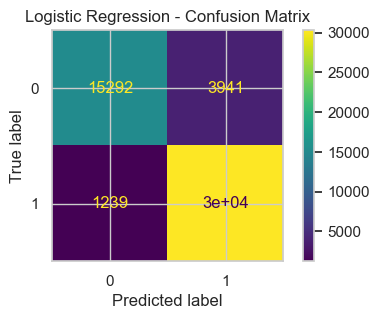

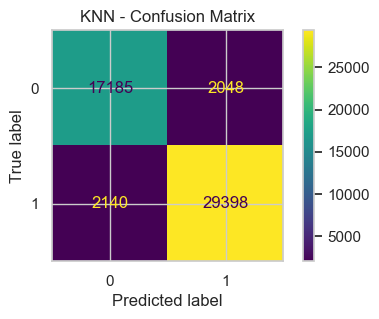

In [40]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN - Confusion Matrix")
plt.show()

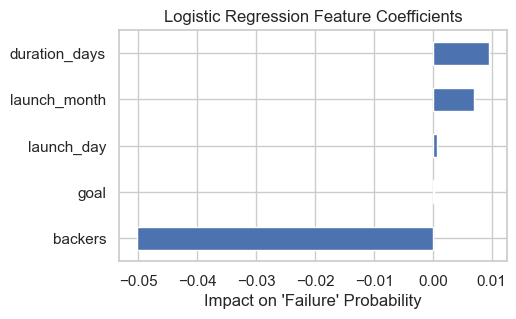

In [41]:
coeffs = pd.Series(logreg.coef_[0], index=X.columns)
coeffs.sort_values().plot(kind='barh')
plt.title("Logistic Regression Feature Coefficients")
plt.xlabel("Impact on 'Failure' Probability")
plt.show()

The feature coefficients are helpful for interpretation. Backers and pledged amount seem to be the strongest predictors.

In [43]:
df.drop(columns=['backers']).sample(5)

,name,category,main_category,goal,lower_title,words,has_album,has_film,has_project,has_book,has_game,has_art,has_music,has_debut,has_documentary,has_life,duration_days,state_encoded,launch_day,launch_month
125971,Last Gasp Books Fall Publishing Season,Publishing,Publishing,75000,last gasp books fall publishing season,"[last, gasp, books, fall, publishing, season]",0,0,0,0,0,0,0,0,0,0,21,0,25,9
77139,Starship Farragut: Homecoming,Science Fiction,Film & Video,15000,starship farragut: homecoming,"[starship, farragut:, homecoming]",0,0,0,0,0,0,0,0,0,0,30,0,1,12
105694,Connecticut only Burmese restaurant,Food,Food,150000,connecticut only burmese restaurant,"[connecticut, only, burmese, restaurant]",0,0,0,0,0,0,0,0,0,0,59,1,18,1
273651,Ice Bunny,Video Games,Games,10000,ice bunny,"[ice, bunny]",0,0,0,0,0,0,0,0,0,0,45,1,23,4
287904,Help Warren Stone Record his Album!,Country & Folk,Music,10000,help warren stone record his album!,"[help, warren, stone, record, his, album!]",1,0,0,0,0,0,0,0,0,0,60,1,26,9


Exclude backers and include title name features 

In [45]:
#define predictor variables and target
X = df[['goal', 'duration_days'] + [f'has_{w}' for w in top_words]]
y = df['state_encoded']

#Test Train Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#baseline accuracy
baseline_accuracy = y_train.value_counts(normalize=True).max()
print("Baseline accuracy:", baseline_accuracy)

#scale predictor variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#KNN
for k in [3, 5, 7, 9, 11 , 15]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    print(f"K={k} - Cross-val accuracy: {scores.mean():.3f}")

#logistic regression
logreg = LogisticRegression(max_iter=1000)

#cross validation
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5)
print("Cross-val accuracy:", cv_scores.mean())

Baseline accuracy: 0.6235931028273005
K=3 - Cross-val accuracy: 0.595
K=5 - Cross-val accuracy: 0.607
K=7 - Cross-val accuracy: 0.616
K=9 - Cross-val accuracy: 0.622
K=11 - Cross-val accuracy: 0.628
K=15 - Cross-val accuracy: 0.633
Cross-val accuracy: 0.6389676857256834


We apply forward feature selection to identify top 5 features 

In [81]:
#define all features (goal, duration_days, title keywords)
X = df[['goal', 'duration_days'] + [f'has_{w}' for w in top_words]]
y = df['state_encoded']

#Test Train Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#logistic regression
logreg = LogisticRegression(max_iter=1000)

#forward feature selection
selector = SequentialFeatureSelector(logreg, n_features_to_select=5, direction='forward', cv=5)
selector.fit(X_train_scaled, y_train)

#print selected features
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print("Selected features:", list(selected_features))

Selected features: ['goal', 'duration_days', 'has_album', 'has_film', 'has_debut']


## Conclusion

This project demonstrates the potential of using simple machine learning models to predict Kickstarter campaign outcomes based on basic project metadata. While we achieved accuracy improvements over a baseline dummy classifier, the models are still far from production-ready.

We found that:
- **Logistic Regression** provided reasonable performance and interpretable coefficients, highlighting the importance of features like number of backers and pledged amount.
- **K-Nearest Neighbors** appeared to overfit the training data, performing well on training but less effectively on the test set.
- Both models, while better than guessing the majority class, still left substantial room for improvement.

### Challenges & Next Steps:
- The overfitting observed, especially in KNN, suggests a need for perhaps **feature scaling**, **regularization**, or **simplification**.
- We haven’t yet made use of potentially informative categorical features like main_category or category.
- Adding **cross-validation**, **feature engineering**, and testing other models (e.g., decision trees, gradient boosting) would be valuable next steps.

While this was a solid start, there’s still a lot of work ahead to build a robust and generalizable model. That said, we're excited to dive into model tuning and optimization since this is the part we all find most engaging. The data cleaning process was a bit frustrating and a bit of a pain sometimes... so we're glad to have made it through that and can now focus on the fun side of machine learning :)



(I know we might do some more cleaning stuff, but we're mostly done with that)